In [11]:
from collections import namedtuple
import numpy as np
import re
from pipe import select, where, sort
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, fbeta_score, make_scorer
from sklearn.preprocessing import LabelEncoder

import presentation as p

with open('data/network-traffic/kddcup.names.dat') as file:
    col_re = r'(\w+)\:.*'
    cols = [re.search(col_re, line)[1] for line in file.readlines()[1:]] + ['target']

training_df = pd.read_csv('data/network-traffic/kddcup.data.csv', names=cols, index_col=False, header=None)
testing_df = pd.read_csv('data/network-traffic/corrected.csv', names=cols, index_col=False, header=None)
complete_df = pd.concat([training_df, testing_df], axis=0)

# Grouping of Attack Types
attack_group_mapping_ = {
    'neptune': 'dos',
    'satan': 'probe',
    'smurf': 'dos',
    'ipsweep': 'probe',
    'portsweep': 'probe',
    'nmap': 'probe',
    'guess_passwd': 'r2l',
    'back': 'dos',
    'mscan': 'probe',
    'warezmaster': 'r2l',
    'teardrop': 'dos',
    'warezclient': 'r2l',
    'apache2': 'dos',
    'processtable': 'dos',
    'saint': 'probe',
    'snmpguess': 'probe',
    'mailbomb': 'dos',
    'pod': 'dos',
    'snmpgetattack': 'dos',
    'httptunnel': 'r2l',
    'buffer_overflow': 'u2r',
    'land': 'dos',
    'multihop': 'r2l',
    'rootkit': 'u2r',
    'named': 'r2l',
    'ps': 'u2r',
    'sendmail': 'r2l',
    'imap': 'r2l',
    'xterm': 'r2l',
    'loadmodule': 'u2r',
    'ftp_write': 'r2l',
    'xlock': 'r2l',
    'phf': 'r2l',
    'perl': 'u2r',
    'xsnoop': 'r2l',
    'udpstorm': 'dos',
    'spy': 'r2l',
    'worm': 'r2l',
    'sqlattack': 'u2r'
}
def is_attack(target):
    match target:
        case 'normal':
            return False
        case _:
            return True
def group_attack_type(a_type): return attack_group_mapping_[a_type] if is_attack(a_type) else a_type

complete_df['target_group'] = complete_df.target.map(group_attack_type)
training_df['target_group'] = training_df.target.map(group_attack_type)
testing_df['target_group'] = testing_df.target.map(group_attack_type)
complete_df['is_attack'] = complete_df.target.map(is_attack)
training_df['is_attack'] = training_df.target.map(is_attack)
testing_df['is_attack'] = testing_df.target.map(is_attack)

# Numeric columns
scalable_columns = [col for col in complete_df.columns if complete_df[col].dtype == 'float64'] +\
                   [col for col in complete_df.columns if complete_df[col].dtype == 'int64' and complete_df[col].nunique() > 2]
scaler = StandardScaler()
complete_df_scaled = complete_df.copy()
complete_df_scaled[scalable_columns] = scaler.fit_transform(complete_df_scaled[scalable_columns])
training_df_scaled = training_df.copy()
training_df_scaled[scalable_columns] = scaler.fit_transform(training_df_scaled[scalable_columns])
testing_df_scaled = testing_df.copy()
testing_df_scaled[scalable_columns] = scaler.fit_transform(testing_df_scaled[scalable_columns])

# Columns with 'object' type
object_column_names = [complete_df[col].name for col in complete_df.columns if complete_df[col].dtype == 'object']

label_encoder = LabelEncoder()
complete_df_enc_le = complete_df.copy()
complete_df_scaled_enc_le = complete_df_scaled.copy()
training_df_enc_le = training_df.copy()
training_df_scaled_enc_le = training_df_scaled.copy()
testing_df_enc_le = testing_df.copy()
testing_df_scaled_enc_le = testing_df_scaled.copy()
for column in object_column_names:
    complete_df_enc_le[column] = label_encoder.fit_transform(complete_df[column])
    complete_df_scaled_enc_le[column] = label_encoder.transform(complete_df_scaled[column])
    training_df_enc_le[column] = label_encoder.transform(training_df[column])
    training_df_scaled_enc_le[column] = label_encoder.transform(training_df_scaled[column])
    testing_df_enc_le[column] = label_encoder.transform(testing_df[column])
    testing_df_scaled_enc_le[column] = label_encoder.transform(testing_df_scaled[column])

training_df_clean = training_df.drop_duplicates()
training_df_scaled_clean = training_df_scaled.drop_duplicates()
training_df_enc_le_clean = training_df_enc_le.drop_duplicates()
training_df_scaled_enc_le_clean = training_df_scaled_enc_le.drop_duplicates()
testing_df_clean = testing_df.drop_duplicates()
testing_df_scaled_clean = testing_df_scaled.drop_duplicates()
testing_df_enc_le_clean = testing_df_enc_le.drop_duplicates()
testing_df_scaled_enc_le_clean = testing_df_scaled_enc_le.drop_duplicates()
complete_df_clean = complete_df.drop_duplicates()
complete_df_scaled_clean = complete_df_scaled.drop_duplicates()
complete_df_enc_le_clean = complete_df_enc_le.drop_duplicates()
complete_df_scaled_enc_le_clean = complete_df_scaled_enc_le.drop_duplicates()

X_train_is_attack = training_df_scaled_enc_le_clean.drop(['target', 'target_group', 'is_attack'], axis=1)
#X_train_attack_group = training_df_enc_le_clean[training_df_scaled_enc_le_clean.is_attack].drop(['target', 'target_group', 'is_attack'], axis=1)
X_train_attack_group = training_df_scaled_enc_le_clean[training_df_scaled_enc_le_clean.is_attack].drop(['target', 'target_group', 'is_attack'], axis=1)
y_train_is_attack = training_df_scaled_enc_le_clean.is_attack
#y_train_attack_group = training_df_enc_le_clean[training_df_scaled_enc_le_clean.is_attack].target_group
y_train_attack_group = training_df_scaled_enc_le_clean[training_df_scaled_enc_le_clean.is_attack].target_group
X_test_is_attack = testing_df_scaled_enc_le_clean.drop(['target', 'target_group', 'is_attack'], axis=1)
#X_test_attack_group = testing_df_enc_le_clean[testing_df_enc_le_clean.is_attack].drop(['target', 'target_group', 'is_attack'], axis=1)
X_test_attack_group = testing_df_scaled_enc_le_clean[testing_df_enc_le_clean.is_attack].drop(['target', 'target_group', 'is_attack'], axis=1)
y_true_is_attack = testing_df_scaled_enc_le_clean.is_attack
#y_true_attack_group = testing_df_enc_le_clean[testing_df_enc_le_clean.is_attack].target_group
y_true_attack_group = testing_df_scaled_enc_le_clean[testing_df_enc_le_clean.is_attack].target_group

# Metrics
beta = 10
fbeta_average = 'weighted'
accuracy_scorer = make_scorer(accuracy_score)
f10_scorer = make_scorer(fbeta_score, beta=beta, average=fbeta_average)

def simple_confusion_matrix(y_true, y_pred, target):
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.blues_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

eval_result = namedtuple('HyperparameterTuningResult', ['model', 'accuracy', 'fbeta'])

def evaluate_model(model, X_test, y_true, beta=beta, average=fbeta_average):
    pred = model.predict(X_test)
    acc = accuracy_score(y_true, pred)
    fbeta = fbeta_score(y_true, pred, beta=beta, average=average)
    #print('-- Training Results --')
    #print(f'Best Parameters:\n{param_string}', end='')
    #print(f'Best Score:\n\t{best_score:.6f}')
    print('\n-- Testing Results --')
    print(f'Accuracy    on Verification Data:\t{acc:.6f}')
    print(f'Fbeta scroe on Verification Data:\t{fbeta:.6f}\n')
    print(classification_report(y_true, pred))
    return eval_result(model, acc, fbeta)

We found the best random forest classifier on the reduced dataset with the following details:

## Attack Detection

```txt
-- Training Results --
Best Parameters:
	n_jobs:	-1
	n_neighbors:	20
	weights:	distance
Best Score:
	0.996397

-- Testing Results --
Accuracy    on Verification Data:	0.926628
Fbeta scroe on Verification Data:	0.926530

              precision    recall  f1-score   support

       False       0.90      0.99      0.94     47913
        True       0.98      0.82      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.92     77291
weighted avg       0.93      0.93      0.93     77291
```

## Attack Classification

```txt
-- Training Results --
Best Parameters:
	n_jobs:	-1
	n_neighbors:	100
	weights:	uniform
Best Score:
	0.977412

-- Testing Results --
Accuracy    on Verification Data:	0.854245
Fbeta scroe on Verification Data:	0.853874

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     23747
           2       0.42      0.67      0.52      3041
           3       0.90      0.18      0.30      2533
           4       0.00      0.00      0.00        57

    accuracy                           0.85     29378
   macro avg       0.57      0.45      0.44     29378
weighted avg       0.88      0.85      0.84     29378
```

Now, we will use this parameterset and train the classifier on the entire dataset.

In [2]:
model_is_attack = KNeighborsClassifier(
    n_neighbors=20,
    weights='distance',
    n_jobs=-1
).fit(X_train_is_attack, y_train_is_attack)

In [3]:
y_pred_is_attack = model_is_attack.predict(X_test_is_attack)

In [4]:
result_is_attack = evaluate_model(model_is_attack, X_test_is_attack, y_true_is_attack)


-- Testing Results --
Accuracy    on Verification Data:	0.926175
Fbeta scroe on Verification Data:	0.926098

              precision    recall  f1-score   support

       False       0.91      0.98      0.94     47913
        True       0.97      0.83      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.92     77291
weighted avg       0.93      0.93      0.92     77291



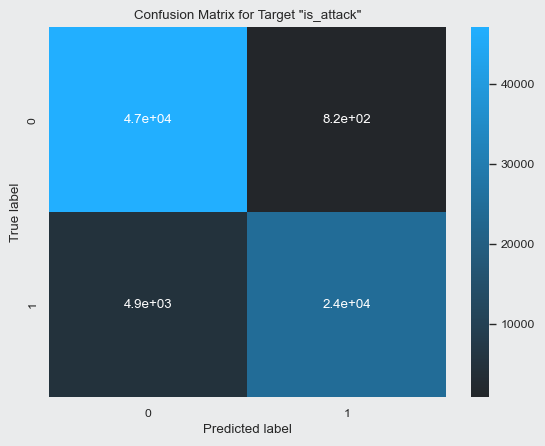

In [5]:
simple_confusion_matrix(y_true_is_attack, y_pred_is_attack, 'is_attack')

In [12]:
model_attack_group = KNeighborsClassifier(
    n_neighbors=100,
    weights='uniform',
    n_jobs=-1
).fit(X_train_attack_group, y_train_attack_group)

In [13]:
y_pred_attack_group = model_attack_group.predict(X_test_attack_group)

In [14]:
result_attack_group = evaluate_model(model_attack_group, X_test_attack_group, y_true_attack_group)


-- Testing Results --
Accuracy    on Verification Data:	0.876098
Fbeta scroe on Verification Data:	0.875650

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     23747
           2       0.56      0.74      0.64      3041
           3       0.97      0.21      0.35      2533
           4       0.00      0.00      0.00        57

    accuracy                           0.88     29378
   macro avg       0.61      0.48      0.48     29378
weighted avg       0.89      0.88      0.86     29378



/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

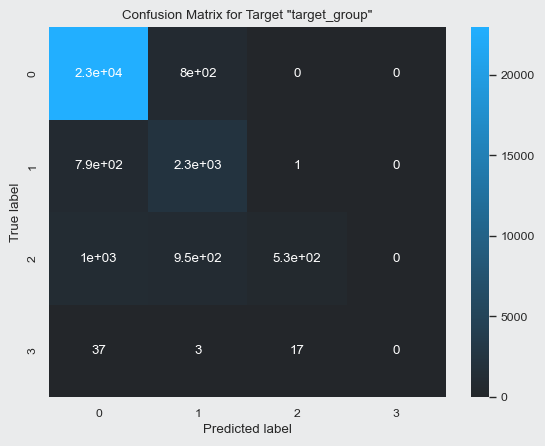

In [15]:
simple_confusion_matrix(y_true_attack_group, y_pred_attack_group, 'target_group')